"""
# Prevenção de Inadimplência em Cartão de Crédito
# Autor: Carlos Eduardo Bearzotti da Silva
# Data: 16/10/2025
# Descrição: Modelo de ML para prever inadimplência em cartões de crédito
"""

In [37]:
import pandas as pd

In [38]:
import numpy as np

In [39]:
import matplotlib.pyplot as plt

In [40]:
import seaborn as sns

In [41]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve)

In [42]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
import joblib
import json

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


# CÉLULA 1: CARREGAMENTO E PRIMEIRA VISÃO DOS DADOS
# Supondo que temos um dataset chamado 'dados_clientes.csv'
# Em um caso real, isso viria do banco de dados

In [46]:
# Exemplo de como carregar os dados
try:
    df = pd.read_csv('dados_clientes.csv')
    print("✅ Dados carregados com sucesso!")
except:
    # Criando dados sintéticos para exemplo
    print("📝 Criando dados sintéticos para demonstração...")
    np.random.seed(42)
    n_samples = 10000

    df = pd.DataFrame({
        'idade': np.random.randint(18, 70, n_samples),
        'renda_mensal': np.random.normal(5000, 2000, n_samples),
        'limite_credito': np.random.normal(10000, 3000, n_samples),
        'utilizacao_limite': np.random.uniform(0, 1, n_samples),
        'qtd_emprestimos_ativos': np.random.randint(0, 5, n_samples),
        'historico_atraso_6m': np.random.randint(0, 4, n_samples),
        'score_serasa': np.random.normal(600, 100, n_samples),
        'tempo_relacionamento_meses': np.random.randint(1, 120, n_samples)
    })

    # Criando variável target baseada em relações lógicas
    prob_inadimplencia = (
        0.1 +
        0.3 * (df['utilizacao_limite'] > 0.8) +
        0.2 * (df['historico_atraso_6m'] > 2) +
        0.15 * (df['score_serasa'] < 500) +
        0.1 * (df['qtd_emprestimos_ativos'] > 3) -
        0.05 * (df['tempo_relacionamento_meses'] > 24)
    )

    df['inadimplente'] = np.random.binomial(1, prob_inadimplencia)

# Visualização inicial
print("📊 Primeiras linhas do dataset:")
print(df.head())
print(f"\n📈 Dimensões do dataset: {df.shape}")
print(f"\n🔍 Informações do dataset:")
print(df.info())
print(f"\n📋 Estatísticas descritivas:")
print(df.describe())

📝 Criando dados sintéticos para demonstração...
📊 Primeiras linhas do dataset:
   idade  renda_mensal  limite_credito  utilizacao_limite  \
0     56   3295.226468    12666.820017           0.401295   
1     69   5950.731221    11060.181392           0.639502   
2     46   6264.908433    11798.930922           0.473291   
3     32   4051.643650    13815.090375           0.021230   
4     60   3456.456085     9550.101126           0.814383   

   qtd_emprestimos_ativos  historico_atraso_6m  score_serasa  \
0                       1                    3    565.871567   
1                       2                    0    536.070482   
2                       1                    2    468.914165   
3                       0                    0    490.386324   
4                       3                    3    541.055558   

   tempo_relacionamento_meses  inadimplente  
0                          99             0  
1                          17             0  
2                          23  

# CÉLULA 2: ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET
inadimplente
0    0.7846
1    0.2154
Name: proportion, dtype: float64


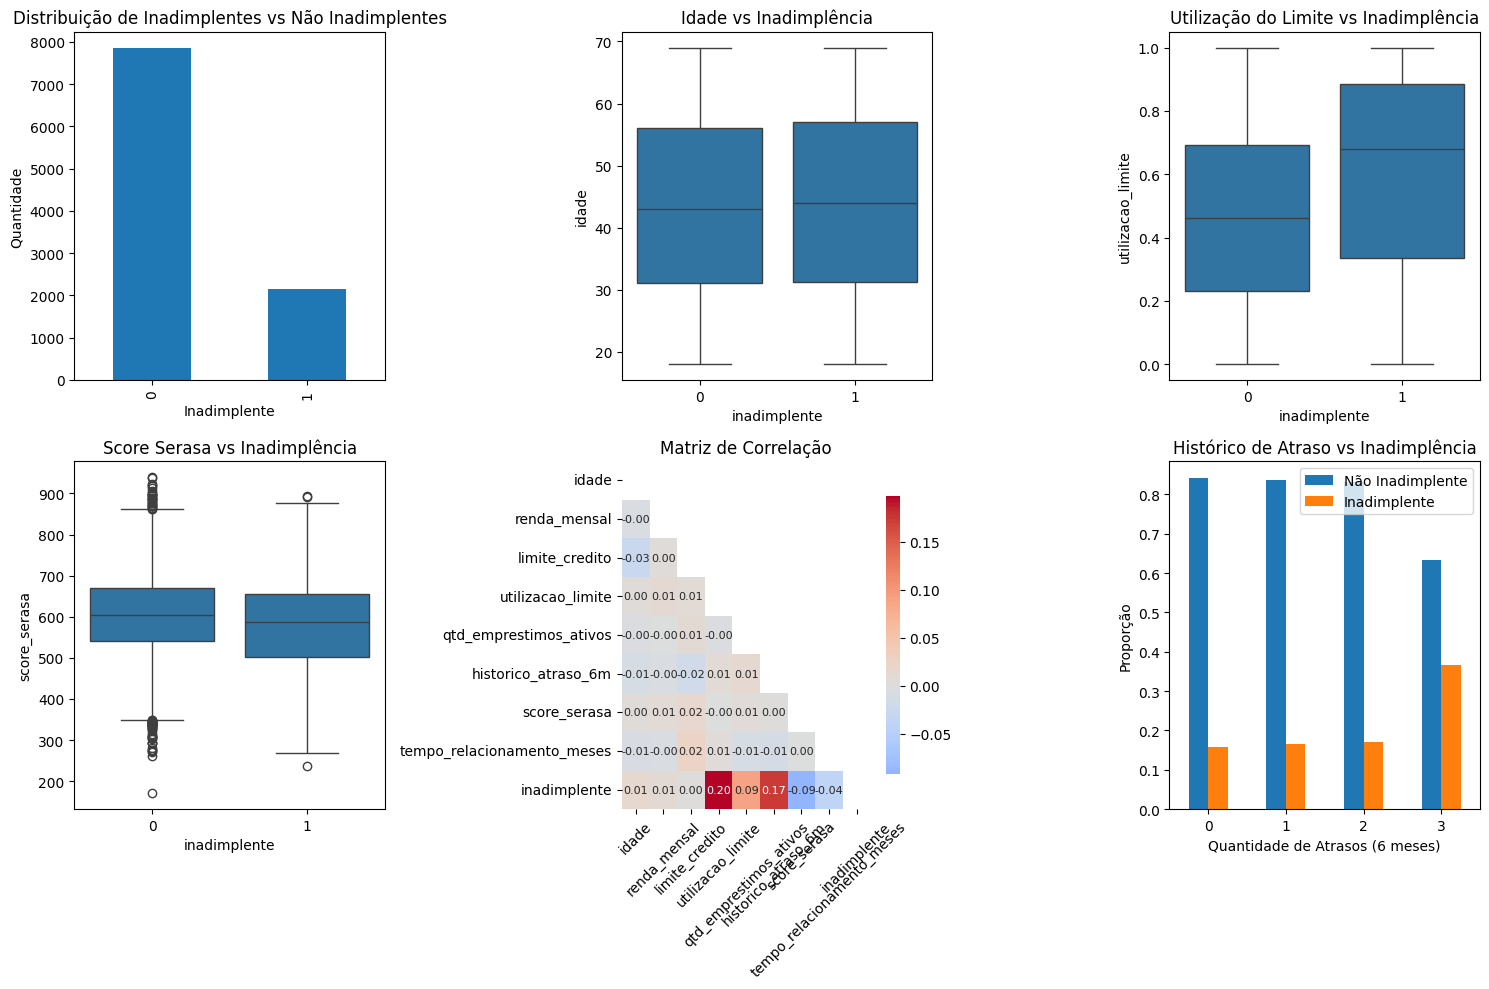

In [62]:
print("🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET")
print(df['inadimplente'].value_counts(normalize=True))

plt.figure(figsize=(15, 10))

# Plot 1: Distribuição do target
plt.subplot(2, 3, 1)
df['inadimplente'].value_counts().plot(kind='bar')
plt.title('Distribuição de Inadimplentes vs Não Inadimplentes')
plt.xlabel('Inadimplente')
plt.ylabel('Quantidade')

# Plot 2: Idade vs Inadimplência
plt.subplot(2, 3, 2)
sns.boxplot(x='inadimplente', y='idade', data=df)
plt.title('Idade vs Inadimplência')

# Plot 3: Utilização do Limite vs Inadimplência
plt.subplot(2, 3, 3)
sns.boxplot(x='inadimplente', y='utilizacao_limite', data=df)
plt.title('Utilização do Limite vs Inadimplência')

# Plot 4: Score Serasa vs Inadimplência
plt.subplot(2, 3, 4)
sns.boxplot(x='inadimplente', y='score_serasa', data=df)
plt.title('Score Serasa vs Inadimplência')

# Plot 5: Matriz de Correlação (CORRIGIDA)
plt.subplot(2, 3, 5)
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', annot_kws={'size': 8}, cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlação')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Plot 6: Histórico de Atraso (CORRIGIDO)
plt.subplot(2, 3, 6)
crosstab_data = pd.crosstab(df['historico_atraso_6m'], df['inadimplente'], normalize='index')
crosstab_data.plot(kind='bar', ax=plt.gca())
plt.title('Histórico de Atraso vs Inadimplência')
plt.xlabel('Quantidade de Atrasos (6 meses)')
plt.ylabel('Proporção')
plt.legend(['Não Inadimplente', 'Inadimplente'])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# CÉLULA 2.5: MATRIZ DE CORRELAÇÃO

🔍 MATRIZ DE CORRELAÇÃO


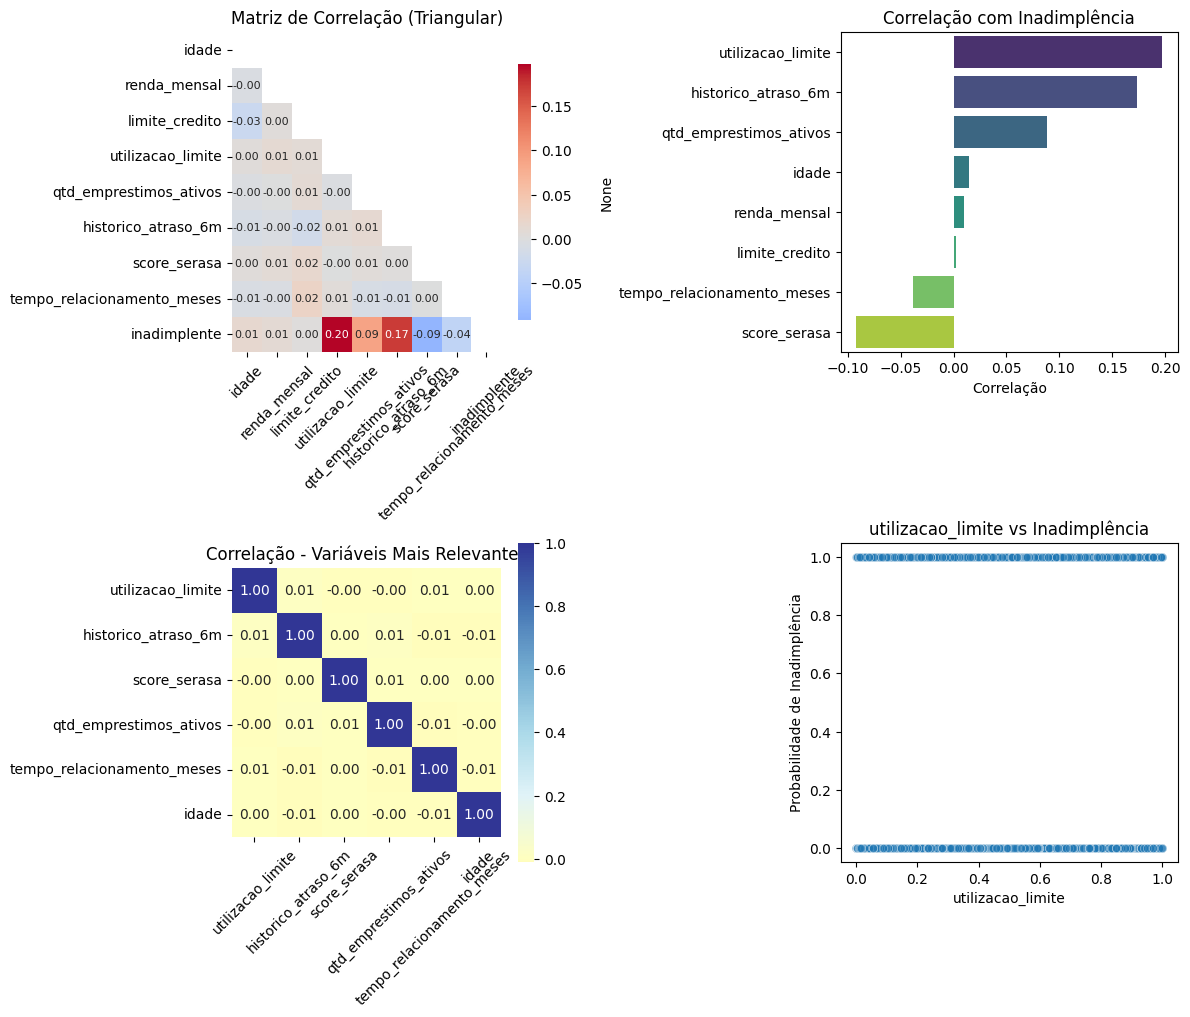


📊 ANÁLISE DAS CORRELAÇÕES:
Correlações com Inadimplência (ordenadas por força):
  utilizacao_limite         :   0.198 (moderada positiva)
  historico_atraso_6m       :   0.174 (moderada positiva)
  qtd_emprestimos_ativos    :   0.088 (fraca positiva)
  idade                     :   0.015 (fraca positiva)
  renda_mensal              :   0.010 (fraca positiva)
  limite_credito            :   0.003 (fraca positiva)
  tempo_relacionamento_meses :  -0.038 (fraca negativa)
  score_serasa              :  -0.092 (fraca negativa)

🔗 CORRELAÇÕES FORTES ENTRE FEATURES:
  Nenhuma correlação forte detectada entre features


In [63]:
print("🔍 MATRIZ DE CORRELAÇÃO")

plt.figure(figsize=(12, 10))

# OPÇÃO 1: Matriz de correlação básica mas legível
plt.subplot(2, 2, 1)
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mascara para mostrar apenas metade
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', annot_kws={'size': 8}, cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlação (Triangular)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# OPÇÃO 2: Focando apenas nas correlações com a target
plt.subplot(2, 2, 2)
corr_with_target = df.corr()['inadimplente'].sort_values(ascending=False)
corr_with_target.drop('inadimplente', inplace=True)  # Remove a correlação consigo mesma
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.title('Correlação com Inadimplência')
plt.xlabel('Correlação')
plt.tight_layout()

# OPÇÃO 3: Matriz de correlação apenas com as variáveis mais relevantes
plt.subplot(2, 2, 3)
# Seleciona as 6 variáveis mais correlacionadas com o target (positiva ou negativamente)
top_features = corr_with_target.abs().sort_values(ascending=False).head(6).index
corr_top = df[top_features].corr()
sns.heatmap(corr_top, annot=True, cmap='RdYlBu', center=0, fmt='.2f',
            square=True, annot_kws={'size': 10})
plt.title('Correlação - Variáveis Mais Relevantes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# OPÇÃO 4: Pairplot das variáveis mais importantes (opcional - pode ser pesado)
plt.subplot(2, 2, 4)
# Gráfico de dispersão da variável mais correlacionada vs target
most_correlated_feature = corr_with_target.index[0]
sns.scatterplot(data=df, x=most_correlated_feature, y='inadimplente', alpha=0.5)
plt.title(f'{most_correlated_feature} vs Inadimplência')
plt.ylabel('Probabilidade de Inadimplência')

plt.tight_layout()
plt.show()

# Análise textual das correlações
print("\n📊 ANÁLISE DAS CORRELAÇÕES:")
print("="*50)
print("Correlações com Inadimplência (ordenadas por força):")
for feature, corr_value in corr_with_target.items():
    direction = "positiva" if corr_value > 0 else "negativa"
    strength = "forte" if abs(corr_value) > 0.3 else "moderada" if abs(corr_value) > 0.1 else "fraca"
    print(f"  {feature:25} : {corr_value:7.3f} ({strength} {direction})")

# Identificando correlações fortes entre features
print(f"\n🔗 CORRELAÇÕES FORTES ENTRE FEATURES:")
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5 and correlation_matrix.columns[i] != 'inadimplente' and correlation_matrix.columns[j] != 'inadimplente':
            strong_correlations.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if strong_correlations:
    for feat1, feat2, corr in strong_correlations:
        print(f"  {feat1:20} ↔ {feat2:20} : {corr:.3f}")
else:
    print("  Nenhuma correlação forte detectada entre features")

# CÉLULA 3: PRÉ-PROCESSAMENTO DOS DADOS

In [48]:
print("🔧 PRÉ-PROCESSAMENTO DOS DADOS")

# Verificando valores nulos
print("Valores nulos por coluna:")
print(df.isnull().sum())

# Tratando valores nulos (se houver)
df = df.fillna(df.median())

# Separando features e target
X = df.drop('inadimplente', axis=1)
y = df['inadimplente']

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"📊 Divisão treino/teste:")
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"Proporção de inadimplentes no treino: {y_train.mean():.3f}")
print(f"Proporção de inadimplentes no teste: {y_test.mean():.3f}")

# Normalizando as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Pré-processamento concluído!")

🔧 PRÉ-PROCESSAMENTO DOS DADOS
Valores nulos por coluna:
idade                         0
renda_mensal                  0
limite_credito                0
utilizacao_limite             0
qtd_emprestimos_ativos        0
historico_atraso_6m           0
score_serasa                  0
tempo_relacionamento_meses    0
inadimplente                  0
dtype: int64
Shape de X: (10000, 8)
Shape de y: (10000,)
📊 Divisão treino/teste:
Treino: 7000 amostras
Teste: 3000 amostras
Proporção de inadimplentes no treino: 0.215
Proporção de inadimplentes no teste: 0.215
✅ Pré-processamento concluído!


# CÉLULA 4: MODELAGEM - MÚLTIPLOS ALGORITMOS

In [49]:
print("🤖 INICIANDO MODELAGEM COM MÚLTIPLOS ALGORITMOS")

# Dicionário para armazenar resultados
results = {}

# 1. Regressão Logística (Baseline)
print("\n1. 🎯 Regressão Logística")
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

results['Logistic Regression'] = {
    'model': lr_model,
    'y_pred': y_pred_lr,
    'y_prob': y_prob_lr
}

# 2. Random Forest
print("2. 🌳 Random Forest")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=10
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

results['Random Forest'] = {
    'model': rf_model,
    'y_pred': y_pred_rf,
    'y_prob': y_prob_rf
}

# 3. Gradient Boosting (XGBoost-like)
print("3. 🚀 Gradient Boosting")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=6
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

results['Gradient Boosting'] = {
    'model': gb_model,
    'y_pred': y_pred_gb,
    'y_prob': y_prob_gb
}

print("✅ Modelos treinados com sucesso!")

🤖 INICIANDO MODELAGEM COM MÚLTIPLOS ALGORITMOS

1. 🎯 Regressão Logística
2. 🌳 Random Forest
3. 🚀 Gradient Boosting
✅ Modelos treinados com sucesso!


# CÉLULA 5: AVALIAÇÃO DOS MODELOS

📊 AVALIAÇÃO COMPARATIVA DOS MODELOS


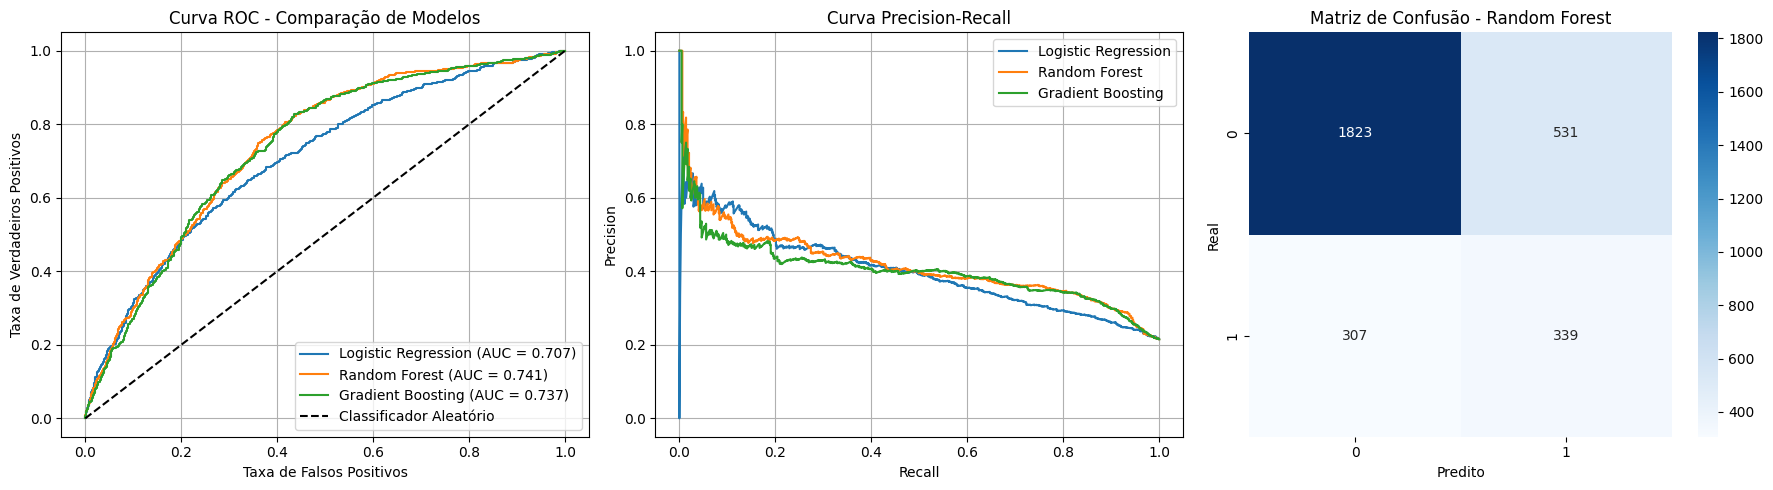


📈 MÉTRICAS DETALHADAS POR MODELO:

🎯 Logistic Regression:
   AUC-ROC: 0.7066
   Acurácia: 0.6517
   Precision (Classe 1): 0.3392
   Recall (Classe 1): 0.6517
   F1-Score (Classe 1): 0.4462

🎯 Random Forest:
   AUC-ROC: 0.7412
   Acurácia: 0.7207
   Precision (Classe 1): 0.3897
   Recall (Classe 1): 0.5248
   F1-Score (Classe 1): 0.4472

🎯 Gradient Boosting:
   AUC-ROC: 0.7367
   Acurácia: 0.7723
   Precision (Classe 1): 0.4369
   Recall (Classe 1): 0.1981
   F1-Score (Classe 1): 0.2726


In [50]:
print("📊 AVALIAÇÃO COMPARATIVA DOS MODELOS")

plt.figure(figsize=(18, 5))

# Plot 1: Curvas ROC
plt.subplot(1, 3, 1)
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    auc_score = roc_auc_score(y_test, result['y_prob'])
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Comparação de Modelos')
plt.legend()
plt.grid(True)

# Plot 2: Curvas Precision-Recall
plt.subplot(1, 3, 2)
for model_name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_prob'])
    plt.plot(recall, precision, label=model_name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)

# Plot 3: Matriz de Confusão do Melhor Modelo
plt.subplot(1, 3, 3)
# Escolhendo o melhor modelo baseado no AUC
best_model_name = max(results.keys(), key=lambda x: roc_auc_score(y_test, results[x]['y_prob']))
best_result = results[best_model_name]

cm = confusion_matrix(y_test, best_result['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.xlabel('Predito')
plt.ylabel('Real')

plt.tight_layout()
plt.show()

# Métricas Detalhadas
print("\n📈 MÉTRICAS DETALHADAS POR MODELO:")
print("="*60)

for model_name, result in results.items():
    y_pred = result['y_pred']
    y_prob = result['y_prob']

    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"\n🎯 {model_name}:")
    print(f"   AUC-ROC: {auc:.4f}")
    print(f"   Acurácia: {report['accuracy']:.4f}")
    print(f"   Precision (Classe 1): {report['1']['precision']:.4f}")
    print(f"   Recall (Classe 1): {report['1']['recall']:.4f}")
    print(f"   F1-Score (Classe 1): {report['1']['f1-score']:.4f}")

# CÉLULA 6: ANÁLISE DE IMPORTÂNCIA DAS VARIÁVEIS

🔍 ANÁLISE DE IMPORTÂNCIA DAS VARIÁVEIS


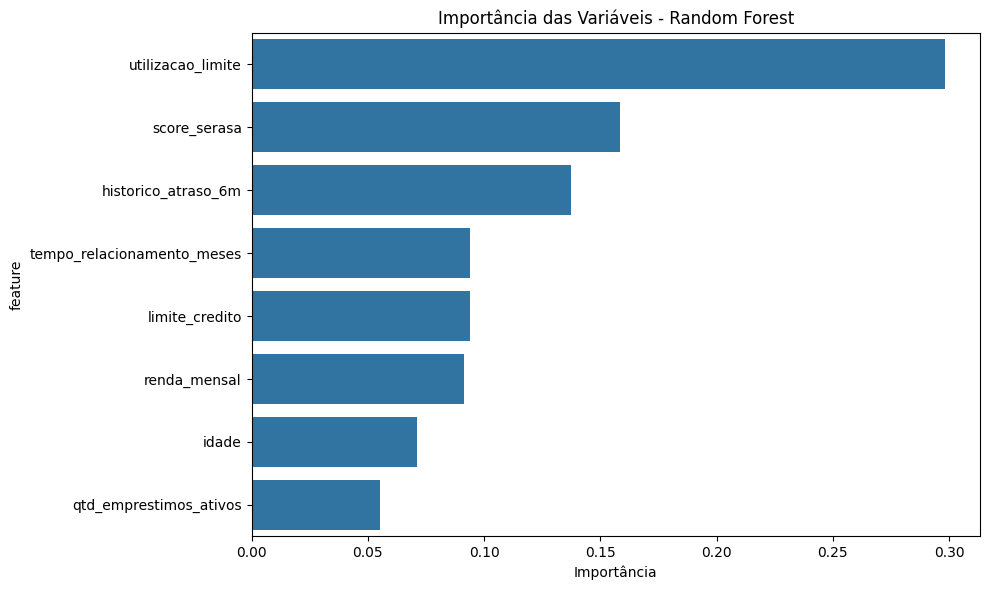

📋 Ranking de Importância das Variáveis:
                      feature  importance
3           utilizacao_limite    0.298416
6                score_serasa    0.158288
5         historico_atraso_6m    0.137579
7  tempo_relacionamento_meses    0.093965
2              limite_credito    0.093920
1                renda_mensal    0.091395
0                       idade    0.071221
4      qtd_emprestimos_ativos    0.055217


In [51]:
print("🔍 ANÁLISE DE IMPORTÂNCIA DAS VARIÁVEIS")

# Para Random Forest (mais interpretável)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Importância das Variáveis - Random Forest')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

print("📋 Ranking de Importância das Variáveis:")
print(feature_importance)

# CÉLULA 7: OTIMIZAÇÃO DE HIPERPARÂMETROS

In [34]:
print("⚙️ OTIMIZAÇÃO DE HIPERPARÂMETROS PARA O MELHOR MODELO")

# Otimizando Random Forest (exemplo)
if best_model_name == 'Random Forest':
    print("Otimizando Random Forest...")

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', None]
    }

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"🎯 Melhores parâmetros: {grid_search.best_params_}")
    print(f"📈 Melhor score (CV): {grid_search.best_score_:.4f}")

    # Modelo final com melhores parâmetros
    best_model = grid_search.best_estimator_

⚙️ OTIMIZAÇÃO DE HIPERPARÂMETROS PARA O MELHOR MODELO
Otimizando Random Forest...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
🎯 Melhores parâmetros: {'class_weight': None, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
📈 Melhor score (CV): 0.7705


# CÉLULA 8: RECOMENDAÇÕES DE NEGÓCIO E CONCLUSÕES

In [35]:
print("💡 RECOMENDAÇÕES DE NEGÓCIO E CONCLUSÕES")

# 1. Análise do Ponto de Corte Ótimo
best_result = results[best_model_name]
precision, recall, thresholds = precision_recall_curve(y_test, best_result['y_prob'])

# Encontrando ponto de corte que balanceia precision e recall
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\n🎯 Ponto de corte ótimo: {optimal_threshold:.3f}")
print(f"   Precision no ponto ótimo: {precision[optimal_idx]:.3f}")
print(f"   Recall no ponto ótimo: {recall[optimal_idx]:.3f}")
print(f"   F1-Score no ponto ótimo: {f1_scores[optimal_idx]:.3f}")

# 2. Simulação de Ações de Negócio
print(f"\n🚀 SIMULAÇÃO DE IMPACTO NO NEGÓCIO:")
n_test = len(y_test)
n_pred_positives = sum(best_result['y_prob'] > optimal_threshold)
n_true_positives = sum((best_result['y_prob'] > optimal_threshold) & (y_test == 1))

print(f"   Total de clientes na base de teste: {n_test}")
print(f"   Clientes identificados como risco: {n_pred_positives} ({n_pred_positives/n_test*100:.1f}%)")
print(f"   Prováveis inadimplentes detectados: {n_true_positives}")

# 3. Recomendações
print(f"\n📋 RECOMENDAÇÕES ESTRATÉGICAS:")
print("   1. 🎯 Segmentação de Clientes:")
print("      - Focar nas variáveis mais importantes: utilização_limite, score_serasa, histórico_atraso")
print("   2. ⚠️  Ações Preventivas:")
print("      - Clientes com alto risco: oferecer renegociação proativa")
print("      - Clientes com risco médio: alertas educativos e monitoramento")
print("   3. 💳 Gestão de Crédito:")
print("      - Revisão de limites para clientes de alto risco")
print("      - Oferecer produtos alternativos (cartão com limite reduzido)")

# 4. Próximos Passos
print(f"\n🔮 PRÓXIMOS PASSOS:")
print("   - Implementar modelo em produção com monitoramento contínuo")
print("   - Desenvolver dashboard para área de risco")
print("   - Validar modelo com dados mais recentes")
print("   - Considerar ensemble de modelos para melhor performance")

💡 RECOMENDAÇÕES DE NEGÓCIO E CONCLUSÕES

🎯 Ponto de corte ótimo: 0.383
   Precision no ponto ótimo: 0.363
   Recall no ponto ótimo: 0.748
   F1-Score no ponto ótimo: 0.489

🚀 SIMULAÇÃO DE IMPACTO NO NEGÓCIO:
   Total de clientes na base de teste: 3000
   Clientes identificados como risco: 1329 (44.3%)
   Prováveis inadimplentes detectados: 482

📋 RECOMENDAÇÕES ESTRATÉGICAS:
   1. 🎯 Segmentação de Clientes:
      - Focar nas variáveis mais importantes: utilização_limite, score_serasa, histórico_atraso
   2. ⚠️  Ações Preventivas:
      - Clientes com alto risco: oferecer renegociação proativa
      - Clientes com risco médio: alertas educativos e monitoramento
   3. 💳 Gestão de Crédito:
      - Revisão de limites para clientes de alto risco
      - Oferecer produtos alternativos (cartão com limite reduzido)

🔮 PRÓXIMOS PASSOS:
   - Implementar modelo em produção com monitoramento contínuo
   - Desenvolver dashboard para área de risco
   - Validar modelo com dados mais recentes
   - Cons

# CÉLULA 9: SALVANDO O MODELO E ARTEFATOS

In [36]:
print("💾 SALVANDO MODELO E ARTEFATOS")

# Salvando o modelo treinado
joblib.dump(best_model, 'modelo_inadimplencia.pkl')
print("✅ Modelo salvo como 'modelo_inadimplencia.pkl'")

# Salvando o scaler
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler salvo como 'scaler.pkl'")

# Salvando metadados do modelo
model_metadata = {
    'model_name': best_model_name,
    'features': list(X.columns),
    'auc_score': float(roc_auc_score(y_test, best_result['y_prob'])),
    'optimal_threshold': float(optimal_threshold),
    'feature_importance': feature_importance.to_dict('records')
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("✅ Metadados do modelo salvos como 'model_metadata.json'")
print("🎉 NOTEBOOK CONCLUÍDO COM SUCESSO!")

💾 SALVANDO MODELO E ARTEFATOS
✅ Modelo salvo como 'modelo_inadimplencia.pkl'
✅ Scaler salvo como 'scaler.pkl'
✅ Metadados do modelo salvos como 'model_metadata.json'
🎉 NOTEBOOK CONCLUÍDO COM SUCESSO!
